## Libraries

In [1]:
import pandas as pd
import numpy as np
import math
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy.stats import linregress
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from statsmodels.othermod.betareg import BetaModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, mean_squared_error, accuracy_score
from patsy import dmatrices
import seaborn as sns
from Bio import SeqIO
from Bio.SeqUtils import gc_fraction
import os
import glob

## Load data

In [ ]:
# Load the TSV file into a DataFrame
all_probes_results_df = pd.read_csv(
    "../data_exports/updated_forced_alignments_analysis_with_nucleotide_diversity_all_probes_results_df.tsv",
    sep="\t",
)

pd.set_option(
    "display.max_columns", None
)  # This sets the option to display all columns when printing the head of the dataframe

print(all_probes_results_df.head())

# Logistic regression starting from scratch

In [ ]:
# Set global font sizes for consistency across all figures
rcParams["font.size"] = 10
rcParams["axes.titlesize"] = 12
rcParams["axes.labelsize"] = 10
rcParams["xtick.labelsize"] = 9
rcParams["ytick.labelsize"] = 9
rcParams["legend.fontsize"] = 9
rcParams["figure.titlesize"] = 14

centimeters = 1 / 2.54  # centimeters in inches

# Plotting Normalized ratio of coverages for MSA
plt.figure(figsize=(16 * centimeters, 10 * centimeters), dpi=300)
plt.grid(True, linestyle="--", alpha=0.7)
plt.scatter(
    all_probes_results_df["genetic_distance"],
    all_probes_results_df["normalized_coverage"],
    color="C0",
    alpha=0.2,
    edgecolors="None",
    s=30,
)
plt.xlabel("Probe-target genetic complementarity")
plt.ylabel("Normalised relative read depth")
plt.ylim([0, 1])
plt.xlim([0.2, 1])
plt.axhline(
    y=0.3,
    color="C1",
    linestyle="--",
    label="Threshold for binning into high or low enrichment",
)
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.legend(loc="upper left")
plt.show()

### Define functions

In [ ]:
def run_logistic_regression(df, dependent_var, independent_vars):
    """
    Run logistic regression with one or multiple independent variables and print out the results.

    :param df: DataFrame containing the variables
    :param dependent_var: Name of the dependent variable column
    :param independent_vars: List of independent variable column names
    :return: Dictionary containing model results and metrics
    """
    X = df[independent_vars]
    y = df[dependent_var]

    # Add constant for statsmodels
    X = sm.add_constant(X)

    # Fit the model
    model = sm.Logit(y, X).fit()

    # Make predictions
    y_pred = model.predict(X)
    y_pred_class = (y_pred > 0.5).astype(int)

    # Calculate metrics
    accuracy = accuracy_score(y, y_pred_class)

    # Print out the statistics
    print(f"AIC: {model.aic:.4f}")
    print(f"BIC: {model.bic:.4f}")
    print("\nModel Summary:")
    print(model.summary())

    result = {
        "model": model,
        "summary": model.summary(),
        "accuracy": accuracy,
        "aic": model.aic,
        "bic": model.bic,
    }

    return result


def interpret_logistic_regression(
    result, df, independent_vars, p_threshold=0.05, decimal_places=3
):
    """
    Interpret logistic regression results with detailed impact analysis of each variable,
    including conversion of log odds to odds ratios and IQR effects.

    :param result: Dictionary containing regression results from run_logistic_regression function
    :param df: DataFrame containing the variables
    :param independent_vars: List of independent variable names
    :param p_threshold: Threshold for statistical significance
    :param decimal_places: Number of decimal places to display in the summary table
    """
    model = result["model"]

    print("\n--- Detailed Logistic Regression Interpretation ---")
    print(f"Dependent Variable: {model.model.endog_names}")
    print(f"Independent Variables: {', '.join(independent_vars)}")
    print(f"\nModel Accuracy: {result['accuracy']:.4f}")

    print("\nVariable Statistics and Effects:")

    # Create a list to store results
    results_list = []

    for var in independent_vars:
        # Calculate descriptive statistics
        desc_stats = df[var].describe()

        # Get coefficient and p-value
        coef = model.params[var]
        p_value = model.pvalues[var]

        # Calculate confidence interval
        ci = model.conf_int().loc[var]
        ci_lower, ci_upper = ci

        # Convert log odds to odds ratio
        odds_ratio = np.exp(coef)
        ci_lower_or = np.exp(ci_lower)
        ci_upper_or = np.exp(ci_upper)

        # Calculate interquartile effect
        q1, q3 = desc_stats["25%"], desc_stats["75%"]
        iqr = q3 - q1
        iqr_log_odds_change = coef * iqr
        iqr_odds_ratio = np.exp(iqr_log_odds_change)
        iqr_ci_lower = np.exp(ci_lower * iqr)
        iqr_ci_upper = np.exp(ci_upper * iqr)

        # Calculate probability change (assuming baseline probability of 0.5)
        baseline_prob = 0.5
        new_prob = (
            baseline_prob
            * iqr_odds_ratio
            / (1 - baseline_prob + (baseline_prob * iqr_odds_ratio))
        )
        prob_change = new_prob - baseline_prob

        # Add results to list
        results_list.append(
            {
                "Variable": var,
                "Coefficient": coef,
                "Odds Ratio": odds_ratio,
                "CI Lower": ci_lower_or,
                "CI Upper": ci_upper_or,
                "p-value": p_value,
                "IQR Odds Ratio": iqr_odds_ratio,
                "IQR CI Lower": iqr_ci_lower,
                "IQR CI Upper": iqr_ci_upper,
            }
        )

        print(f"\n{var}:")
        print(f"  Coefficient (log odds): {coef:.4f}")
        print(
            f"  Odds Ratio: {odds_ratio:.4f} (95% CI: [{ci_lower_or:.4f}, {ci_upper_or:.4f}])"
        )
        print(f"  p-value: {p_value:.4f}")
        print(f"  Mean: {desc_stats['mean']:.4f}")
        print(f"  Std Dev: {desc_stats['std']:.4f}")
        print(f"  Range: {desc_stats['min']:.4f} to {desc_stats['max']:.4f}")
        print(f"  Interquartile Range: {iqr:.4f} (from {q1:.4f} to {q3:.4f})")
        print(
            f"  Effect of IQR change on odds: {iqr_odds_ratio:.4f} (95% CI: [{iqr_ci_lower:.4f}, {iqr_ci_upper:.4f}])"
        )
        print(
            f"  Effect of IQR change on probability: {prob_change:.4f} ({prob_change*100:.2f} percentage points)"
        )

        if p_value < p_threshold:
            print(
                f"  This effect is statistically significant at the {p_threshold:.3f} level."
            )
        else:
            print(
                f"  This effect is not statistically significant at the {p_threshold:.3f} level."
            )

    # Create DataFrame from results list
    results_df = pd.DataFrame(results_list)

    # Format the DataFrame
    formatted_df = results_df.style.format(
        {
            "Coefficient": f"{{:.{decimal_places}f}}",
            "Odds Ratio": f"{{:.{decimal_places}e}}",
            "CI Lower": f"{{:.{decimal_places}e}}",
            "CI Upper": f"{{:.{decimal_places}e}}",
            "p-value": lambda x: (
                f"{x:.{decimal_places}f}" if x >= 0.001 else f"{x:.{decimal_places}e}"
            ),
            "IQR Odds Ratio": f"{{:.{decimal_places}f}}",
            "IQR CI Lower": f"{{:.{decimal_places}f}}",
            "IQR CI Upper": f"{{:.{decimal_places}f}}",
        }
    )

    # Print summary table with specified decimal places
    print("\nSummary Table:")
    print(formatted_df.to_string())

    return results_df

## Pre-processing data for regression

In [ ]:
# Create a copy of the DataFrame
df_copy = all_probes_results_df.copy()

# Print the initial size of the DataFrame
print(f"Initial size of the DataFrame: {df_copy.shape[0]} rows")

# Threshold for binary binning coverage_ratio values into high and low enrichment
threshold = 0.3

# Bin the coverage_ratio column
df_copy["high_enrichment"] = (df_copy["normalized_coverage"] > threshold).astype(int)

# Remove any rows with NaN. I think these exist because genetic distance wasn't calculated for force alignment regions with many "N" characters
df_copy = df_copy.dropna()

# Print the final size of the DataFrame
print(f"Final size of the DataFrame after processing: {df_copy.shape[0]} rows")

# Calculate and print the number of rows dropped
rows_dropped = all_probes_results_df.shape[0] - df_copy.shape[0]
print(f"Number of rows dropped: {rows_dropped}")


# Check how skewed my binning is
def explore_coverage_ratio_distribution(df, coverage_ratio_col, threshold):
    total_samples = len(df)
    high_coverage = df[df[coverage_ratio_col] > threshold]
    low_coverage = df[df[coverage_ratio_col] <= threshold]

    print(f"\n--- Coverage Ratio Distribution (Threshold: {threshold}) ---")
    print(f"Total samples: {total_samples}")
    print(
        f"High coverage ratio samples: {len(high_coverage)} ({len(high_coverage)/total_samples*100:.2f}%)"
    )
    print(
        f"Low coverage ratio samples: {len(low_coverage)} ({len(low_coverage)/total_samples*100:.2f}%)"
    )


# Checking how different cutoffs would affect the size of the two bins
for test_threshold in [0.1, 0.2, 0.3, 0.4]:
    explore_coverage_ratio_distribution(df_copy, "normalized_coverage", test_threshold)

### Genetic distance, complementary GC content, nucleotide diversity

In [ ]:
# Logistic regression for a single independent variable
result = run_logistic_regression(df_copy, "high_enrichment", ["genetic_distance"])
results_df_1 = interpret_logistic_regression(result, df_copy, ["genetic_distance"])

print("\n" + "—.-" * 50 + "\n")

result = run_logistic_regression(
    df_copy, "high_enrichment", ["genetic_distance", "gc_complementary"]
)
results_df_2 = interpret_logistic_regression(
    result, df_copy, ["genetic_distance", "gc_complementary"]
)

print("\n" + "—.-" * 50 + "\n")

result = run_logistic_regression(
    df_copy,
    "high_enrichment",
    ["genetic_distance", "gc_complementary", "avg_nucleotide_diversity"],
)
results_df_3 = interpret_logistic_regression(
    result,
    df_copy,
    ["genetic_distance", "gc_complementary", "avg_nucleotide_diversity"],
)

# print("\n" + "—.-" * 50 + "\n")

# result = run_logistic_regression(
#     df_copy,
#     "high_enrichment",
#     ["genetic_distance", "gc_complementary", "avg_nucleotide_diversity", "viral_load"],
# )
# results_df = interpret_logistic_regression(
#     result, df_copy, ["genetic_distance", "gc_complementary", "avg_nucleotide_diversity", "viral_load"]
# )

### Calculating effect over GC content IQR manually as a sanity check

In [ ]:
# Step 1: Extract relevant values from the regression output
coefficient = 0.0394  # Log odds for gc_complementary
iqr = 62.9630 - 55.8366  # Interquartile range for gc_complementary

# Step 2: Calculating change in log odds over the IQR:
# 1. The coefficient (0.0394) represents the change in log odds for a 1-unit increase in gc_complementary.
# 2. We multiply this by the IQR (7.1264) because:
#    a) Logistic regression assumes a linear relationship between predictors and log odds.
#    b) This linearity means the effect scales directly with the change in the predictor.
# 3. The result (0.2808) is the total change in log odds when gc_complementary increases from its 25th to 75th percentile.
# 4. We then convert this to an odds ratio and probability for easier interpretation.
# Note: While this relationship is linear in log odds, it becomes non-linear when converted to probabilities.
log_odds_change = coefficient * iqr
print(f"Change in log odds over IQR: {log_odds_change}")

# Step 3: Convert change in log odds to odds ratio
odds_ratio = math.exp(log_odds_change)
print(f"Odds ratio for IQR change: {odds_ratio}")

# Step 4: Calculate probability change
# As a standard, could assume a baseline probability of 0.5 (50% chance of high enrichment)
baseline_prob = 0.7363  # Instead of a baseline probability of 0.5, take the fraction of high enrichment data points in the dataset given the threshold of 0.3 that was used as a baseline probability
baseline_odds = baseline_prob / (1 - baseline_prob)  # Convert probability to odds

new_odds = baseline_odds * odds_ratio
new_prob = new_odds / (1 + new_odds)  # Convert odds back to probability

prob_change = new_prob - baseline_prob
print(f"Probability change: {prob_change}")
print(f"Percentage point change: {prob_change * 100}")

# Optional: Calculate confidence interval
ci_lower = math.exp(0.0079 * iqr)  # Using lower bound of 95% CI for coefficient
ci_upper = math.exp(0.0734 * iqr)  # Using upper bound of 95% CI for coefficient

lower_prob_change = (baseline_odds * ci_lower) / (
    1 + baseline_odds * ci_lower
) - baseline_prob
upper_prob_change = (baseline_odds * ci_upper) / (
    1 + baseline_odds * ci_upper
) - baseline_prob

print(
    f"95% CI for probability change: [{lower_prob_change * 100}, {upper_prob_change * 100}] percentage points"
)

### Partial dependence plots
TODO: currently the plotting function uses its own regression model, which is also from another library. But i want it to use the exact same regression that I run before to print out the results. So far that has only resulted in errors so I haven't managed to change it.

In [ ]:
# Set global font sizes
rcParams["font.size"] = 10
rcParams["axes.titlesize"] = 12
rcParams["axes.labelsize"] = 10
rcParams["xtick.labelsize"] = 9
rcParams["ytick.labelsize"] = 9
rcParams["legend.fontsize"] = 9
rcParams["figure.titlesize"] = 14

# Set color scheme
CB_color_cycle = [
    "#377eb8",
    "#ff7f00",
    "#4daf4a",
    "#f781bf",
    "#a65628",
    "#984ea3",
    "#999999",
    "#e41a1c",
    "#dede00",
]
plt.rc("axes", prop_cycle=plt.cycler("color", CB_color_cycle))


def plot_partial_dependence(df, dependent_var, independent_vars, sk_model):
    """
    Plot partial dependence for multiple independent variables.
    """
    centimeters = 1 / 2.54  # centimeters in inches
    fig, axes = plt.subplots(
        len(independent_vars),
        1,
        figsize=(16 * centimeters, 10 * centimeters * len(independent_vars)),
        dpi=300,
    )
    if len(independent_vars) == 1:
        axes = [axes]

    for i, (ax, var) in enumerate(zip(axes, independent_vars)):
        # Calculate partial dependence
        x_min, x_max = df[var].min(), df[var].max()
        x_range = x_max - x_min
        x_plot = np.linspace(x_min, x_max, 100)
        X_plot = df[independent_vars].copy()
        pd_vals = []
        for val in x_plot:
            X_plot[var] = val
            pd_vals.append(sk_model.predict_proba(X_plot)[:, 1].mean())

        # Add grid
        ax.grid(True, linestyle="--", alpha=0.7)

        # Plot partial dependence
        ax.plot(x_plot, pd_vals, color=CB_color_cycle[0])
        if var == "genetic_distance":
            ax.set_xlabel("Probe-target genetic complementarity")
            ax.set_ylabel("Partial Dependence")
        elif var == "gc_complementary":
            ax.set_xlabel("Complementary GC content (%)")
            ax.set_ylabel("Partial Dependence")
        else:
            ax.set_xlabel(var.replace("_", " ").title())
            ax.set_ylabel("Partial Dependence")

        # Add rug plot
        ax.plot(df[var], np.zeros_like(df[var]), "|", ms=10, color="k", alpha=0.1)

        # Calculate and plot 25th and 75th percentiles
        q1, q3 = df[var].quantile([0.25, 0.75])
        ax.axvline(q1, color=CB_color_cycle[1], linestyle="--", label="25th percentile")
        ax.axvline(q3, color=CB_color_cycle[2], linestyle="--", label="75th percentile")

        # Set axis limits
        ax.set_xlim(x_min - 0.1 * x_range, x_max + 0.1 * x_range)
        ax.set_ylim(-0.05, 1.05)
        ax.legend(loc="upper left")

        # Despine the top and right axes
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

        # Add subplot label
        label = chr(97 + i)  # 97 is ASCII for 'a'
        ax.text(
            -0.1,
            1.1,
            f"{label}",
            transform=ax.transAxes,
            fontsize=14,
            fontweight="bold",
            va="top",
            ha="right",
        )

    plt.tight_layout()
    plt.show()


# Example usage
X = df_copy[["genetic_distance", "gc_complementary"]]
y = df_copy["high_enrichment"]
log_fit = LogisticRegression().fit(X, y)

plot_partial_dependence(
    df_copy, "high_enrichment", ["genetic_distance", "gc_complementary"], log_fit
)

In [ ]:
def plot_logistic_scatter(df, dependent_var, independent_var, model):
    """
    Create a scatter plot with logistic regression fit for a single independent variable.
    """
    centimeters = 1 / 2.54  # centimeters in inches
    plt.figure(figsize=(16 * centimeters, 10 * centimeters), dpi=300)

    # Scatter plot
    plt.scatter(
        df[independent_var],
        df[dependent_var],
        alpha=0.3,
        color=CB_color_cycle[0],
        edgecolors="None",
        s=30,
    )

    # Sort the independent variable for smooth curve plotting
    x_sorted = np.sort(df[independent_var])
    X_pred = pd.DataFrame(
        {independent_var: x_sorted}
    )  # Create DataFrame for prediction
    y_pred = model.predict_proba(X_pred)[:, 1]

    # Plot the fitted curve
    plt.plot(x_sorted, y_pred, color=CB_color_cycle[1], linewidth=2)

    # Set labels and title
    if independent_var == "genetic_distance":
        plt.xlabel("Probe-target genetic complementarity")
    elif independent_var == "gc_complementary":
        plt.xlabel("Complementary GC content (%)")
    else:
        plt.xlabel(independent_var.replace("_", " ").title())

    plt.ylabel(f"Probability of {dependent_var.replace('_', ' ').title()}")
    plt.title(
        f"Logistic Regression: {dependent_var.replace('_', ' ').title()} vs {independent_var.replace('_', ' ').title()}"
    )

    # Add grid
    plt.grid(True, linestyle="--", alpha=0.7)

    # Despine the top and right axes
    ax = plt.gca()
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # Set y-axis limits
    plt.ylim(-0.05, 1.05)

    plt.tight_layout()
    plt.show()


# Example usage
X = df_copy[
    ["genetic_distance"]
]  # Using only one independent variable for scatter plot
y = df_copy["high_enrichment"]
sk_model = LogisticRegression().fit(X, y)

plot_logistic_scatter(df_copy, "high_enrichment", "genetic_distance", sk_model)

### Hydrogen bond score

In [ ]:
# Logistic regression for a single independent variable
result = run_logistic_regression(df_copy, "high_enrichment", ["hydrogen_bond_score"])

print("\n" + "—.-" * 50 + "\n")

# Logistic regression for multiple independent variables
result = run_logistic_regression(
    df_copy, "high_enrichment", ["hydrogen_bond_score", "avg_nucleotide_diversity"]
)

## Sensitvity analysis using different thresholds

In [ ]:
# def threshold_sensitivity_analysis(df, thresholds, models):
#     """
#     Perform sensitivity analysis on threshold values for logistic regression models.

#     :param df: DataFrame containing the data
#     :param thresholds: List of threshold values to test
#     :param models: Dictionary of model names and their independent variables
#     """
#     results = {}

#     for threshold in thresholds:
#         print(f"\nThreshold: {threshold}")
#         print("-" * 20)

#         # Create high_enrichment column based on the current threshold
#         df[f"high_enrichment_{threshold}"] = (
#             df["coverage_ratio"] > threshold
#         ).astype(int)

#         for model_name, independent_vars in models.items():
#             # Run logistic regression
#             X = sm.add_constant(df[independent_vars])
#             y = df[f"high_enrichment_{threshold}"]
#             model = sm.Logit(y, X).fit(disp=0)

#             # Extract p-value for gc_complementary if it's in the model
#             if "gc_complementary" in independent_vars:
#                 gc_p_value = model.pvalues["gc_complementary"]
#                 results.setdefault(model_name, {})[threshold] = gc_p_value

#                 print(f"{model_name}:")
#                 print(f"  gc_complementary p-value: {gc_p_value:.4f}")
#             else:
#                 print(f"{model_name}: gc_complementary not in model")

#     return results


# # Example usage:
# thresholds = [10, 20, 30]
# models = {
#     "Model 1": ["genetic_distance", "gc_complementary"],
#     "Model 2": ["genetic_distance", "gc_complementary", "avg_nucleotide_diversity"],
#     "Model 3": [
#         "genetic_distance",
#         "gc_complementary",
#         "avg_nucleotide_diversity",
#         "viral_load",
#     ],
# }

# sensitivity_results = threshold_sensitivity_analysis(df_copy, thresholds, models)

# # Print summary table
# print("\nSensitivity Analysis Summary:")
# print("-" * 40)
# print("Model | Threshold 10 | Threshold 20 | Threshold 30")
# print("-" * 40)
# for model_name, threshold_results in sensitivity_results.items():
#     p_values = [threshold_results.get(t, "N/A") for t in thresholds]
#     print(f"{model_name} | {p_values[0]:.4f} | {p_values[1]:.4f} | {p_values[2]:.4f}")

# GC content of assembly sequences

## Combine FASTA files

In [ ]:
# Specify the directory containing your FASTA files
directory = "../gc_content_of_assemblies/precapture_assemblies"

# Use glob to get all .fasta files in the directory
fasta_files = glob.glob(os.path.join(directory, "*.fa"))

# Open a new file to write the combined FASTA content
with open(
    "../gc_content_of_assemblies/precapture_assemblies/15_precapture_assemblies.fasta",
    "w",
) as outfile:
    # Iterate through each FASTA file
    for fasta_file in fasta_files:
        # Parse the FASTA file and write each record to the combined file
        for record in SeqIO.parse(fasta_file, "fasta"):
            SeqIO.write(record, outfile, "fasta")

print(f"Combined {len(fasta_files)} FASTA files into combined_fasta.fasta")

# Specify the directory containing your FASTA files
directory = "../gc_content_of_assemblies/post_capture_assemblies/"

# Use glob to get all .fasta files in the directory
fasta_files = glob.glob(os.path.join(directory, "*.fa"))

# Open a new file to write the combined FASTA content
with open(
    "../gc_content_of_assemblies/post_capture_assemblies/15_post_capture_assemblies.fasta",
    "w",
) as outfile:
    # Iterate through each FASTA file
    for fasta_file in fasta_files:
        # Parse the FASTA file and write each record to the combined file
        for record in SeqIO.parse(fasta_file, "fasta"):
            SeqIO.write(record, outfile, "fasta")

print(f"Combined {len(fasta_files)} FASTA files into combined_fasta.fasta")

## Print out GC content

In [ ]:
# Path to combined FASTA file
fasta_file = "../gc_content_of_assemblies/post_capture_assemblies/15_post_capture_assemblies.fasta"

# Create a list to store the results
results = []

# Read the FASTA file and calculate GC content for each sequence
for record in SeqIO.parse(fasta_file, "fasta"):
    sequence = record.seq
    gc_content = gc_fraction(sequence) * 100  # Convert to percentage
    results.append({"Sequence_ID": record.id, "GC_Content": gc_content})

# Create a DataFrame from the results
gc_df = pd.DataFrame(results)

# Display the results
print(gc_df)

# Print the lowest and highest GC percentages
lowest_gc = gc_df.loc[gc_df["GC_Content"].idxmin()]
highest_gc = gc_df.loc[gc_df["GC_Content"].idxmax()]

print("\nSummary:")
print(
    f"Lowest GC content: {lowest_gc['GC_Content']:.2f}% (Sequence: {lowest_gc['Sequence_ID']})"
)
print(
    f"Highest GC content: {highest_gc['GC_Content']:.2f}% (Sequence: {highest_gc['Sequence_ID']})"
)

# Off-target GC content before and after enrichment

In [4]:
# Load mapped PacBio data of negative control samples pre- vs. post-enrichment
off_target_gc = pd.read_excel(
    "../off_target_gc_content/off_target_gc_content.xls",
    sheet_name="Sheet1",
    engine="xlrd",
)

print(off_target_gc.columns)

# Rename columns
off_target_gc.columns = [
    "seq_method",
    "condition",
    "chrM",
    "chr1",
    "chr2",
    "chr3",
    "chr4",
    "chr5",
    "chr6",
    "chr7",
    "chr8",
    "chr9",
    "chr10",
    "chr11",
    "chr12",
    "chr13",
    "chr14",
    "chr15",
    "chr16",
    "chr17",
    "chr18",
    "chr19",
    "chr20",
    "chr21",
    "chr22",
    "chrRan",
    "chrUn",
    "chrX",
    "chrY",
    "EBV",
    "Total",
]

# # Remove rows containing only zeros, as these skew the data
# off_target_gc = off_target_gc[off_target_gc['condition'] != '1000_15B_5_ProtK_rep2'].reset_index(drop=True)

print("Head of off_target_gc:\n", off_target_gc.head())

# Melt the DataFrame
chromosome_cols = [col for col in off_target_gc.columns if col.startswith("chr")]
melted_df = pd.melt(
    off_target_gc,
    id_vars=["seq_method", "condition"],
    value_vars=chromosome_cols,
    var_name="chromosome",
    value_name="gc_percentage",
)

print(melted_df.shape)

# Filter out rows where gc_percentage is 0, which is likely due to mistakes in wet lab protocol or sequencing
melted_df = melted_df[melted_df["gc_percentage"] != 0]
print(melted_df.shape)

Index(['Unnamed: 0', 'Unnamed: 1', 'chrM', 'chr1', 'chr2', 'chr3', 'chr4',
       'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12',
       'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20',
       'chr21', 'chr22', 'chrRan', 'chrUn', 'chrX', 'chrY', 'EBV', 'Total'],
      dtype='object')
Head of off_target_gc:
   seq_method              condition       chrM       chr1       chr2  \
0       meta  1000_45B_0_ProtK_rep1  45.413870  47.416076  46.831529   
1       meta  1000_45B_0_ProtK_rep2  44.232602  48.084772  47.733713   
2       meta  1000_45B_1_ProtK_rep1  43.827160  47.201857  46.944430   
3       meta  1000_45B_1_ProtK_rep2  45.921986  47.653953  47.262127   
4       meta  1000_45B_5_ProtK_rep1  46.957878  47.455112  48.390441   

        chr3       chr4       chr5       chr6       chr7  ...      chr19  \
0  46.633892  47.442088  46.468000  46.504763  46.976108  ...  51.039543   
1  47.426822  46.472667  46.591972  47.313294  47.598991  ...  5

## Plotting off-target GC

### Simple boxplots

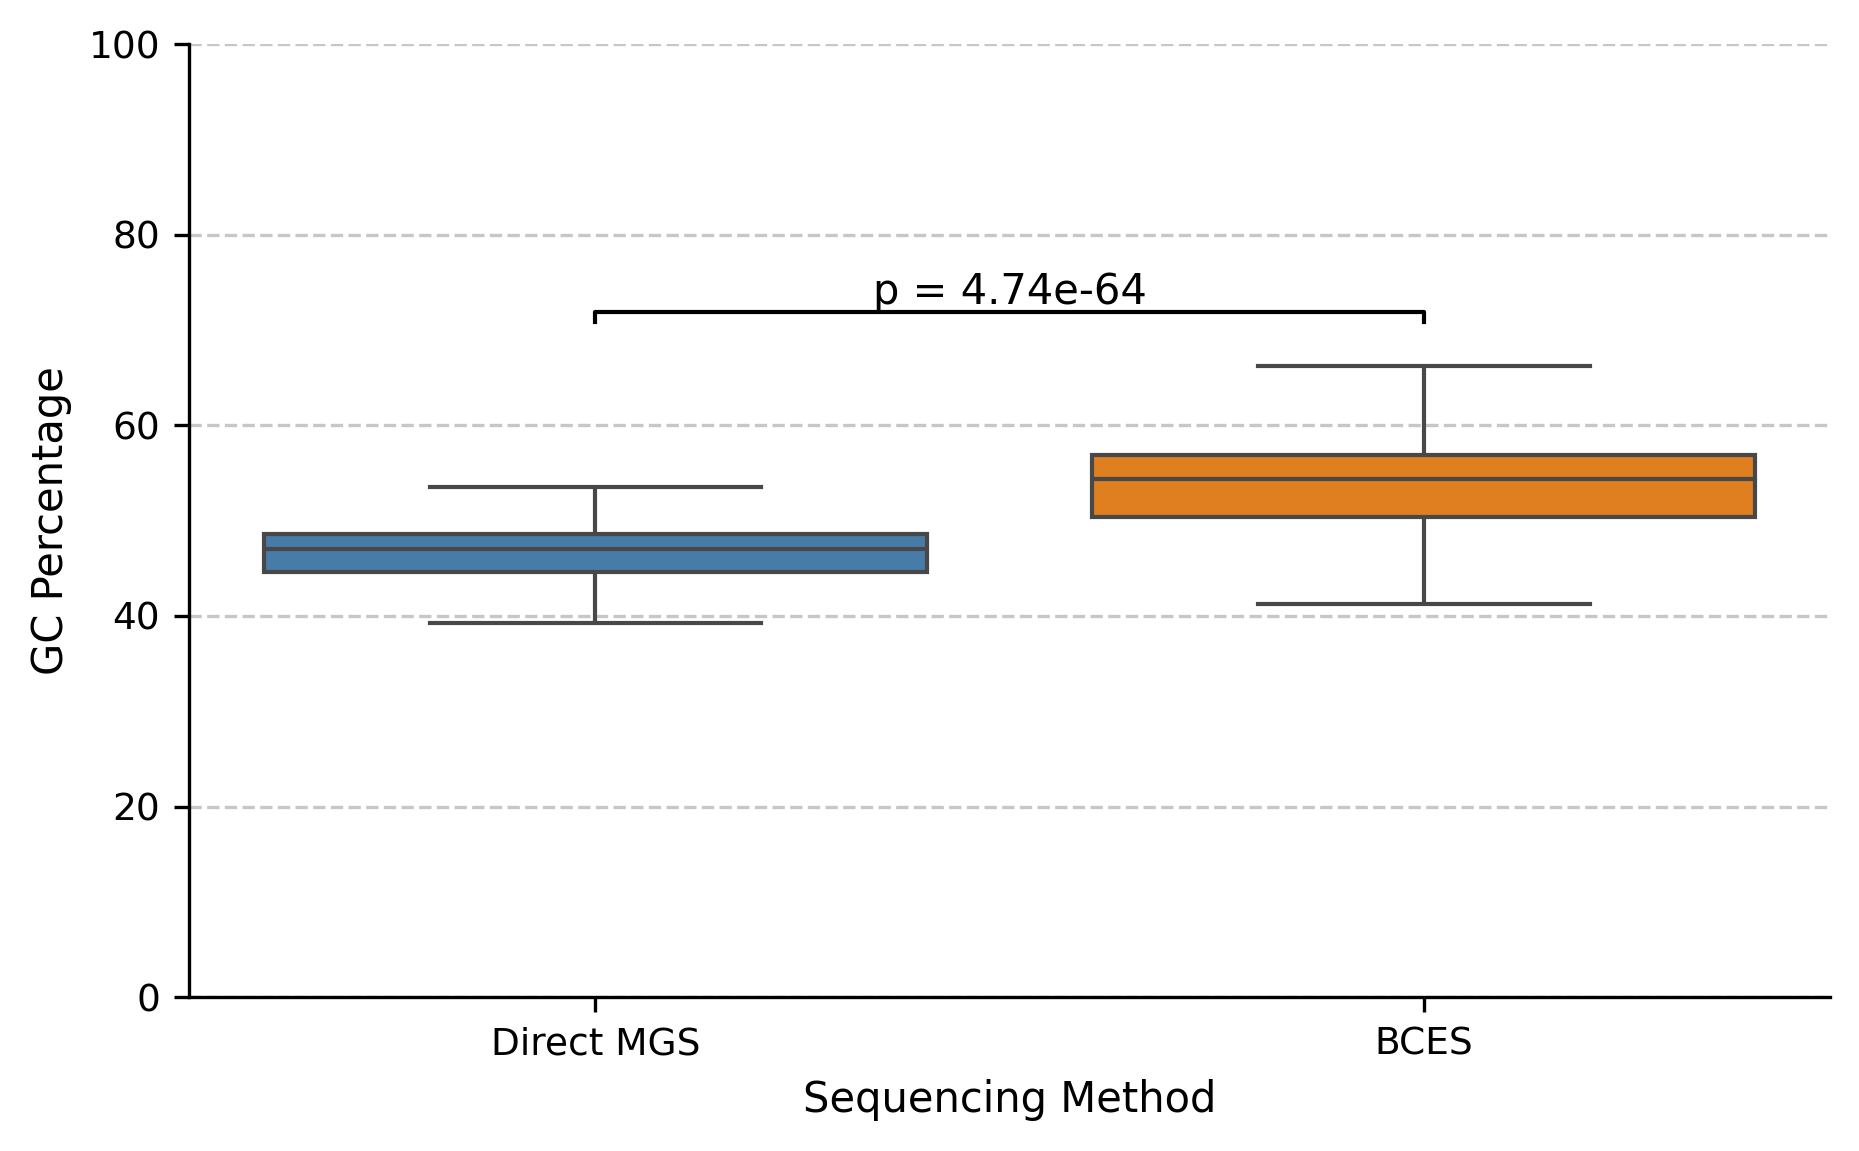


Mann-Whitney U test results:
Statistic: 29982.0
p-value: 4.737283863546272e-64
Mean GC by method for raw dataframe:
 seq_method
captured    53.028154
meta        46.366667
Name: gc_percentage, dtype: float64


In [117]:
# Set global font sizes
rcParams["font.size"] = 10
rcParams["axes.titlesize"] = 12
rcParams["axes.labelsize"] = 10
rcParams["xtick.labelsize"] = 9
rcParams["ytick.labelsize"] = 9
rcParams["legend.fontsize"] = 9
rcParams["figure.titlesize"] = 14

# Create the plot
centimeters = 1 / 2.54  # centimeters in inches
plt.figure(figsize=(16 * centimeters, 10 * centimeters), dpi=300)
plt.grid(True, linestyle="--", alpha=0.7)

# Create the boxplot
sns.boxplot(
    x="seq_method",
    y="gc_percentage",
    hue="seq_method",
    data=melted_df,
    legend=False,
    showfliers=False,
)
plt.xlabel("Sequencing Method")
plt.ylabel("GC Percentage")
plt.ylim(0, 100)


# Add statistical annotation
def add_stat_annotation(ax):
    y_max = melted_df["gc_percentage"].max()
    x1, x2 = 0, 1
    y, h = y_max + 1, 1
    plt.plot(
        [x1, x1, x2, x2], [y, y + h, y + h, y], lw=1, color="black"
    )  # Set line color to black
    stat, p = stats.mannwhitneyu(
        melted_df[melted_df["seq_method"] == "meta"]["gc_percentage"],
        melted_df[melted_df["seq_method"] == "captured"]["gc_percentage"],
    )
    plt.text(
        (x1 + x2) * 0.5, y + h, f"p = {p:.2e}", ha="center", va="bottom", color="black"
    )  # Set text color to black


add_stat_annotation(plt.gca())

ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.set_xticks([0, 1])  # Set the tick locations
ax.set_xticklabels(["Direct MGS", "BCES"])  # Set the tick labels

plt.tight_layout()
plt.show()

# Perform Mann-Whitney U test
meta = melted_df[melted_df["seq_method"] == "meta"]["gc_percentage"]
captured = melted_df[melted_df["seq_method"] == "captured"]["gc_percentage"]
stat, p = stats.mannwhitneyu(meta, captured)
print(f"\nMann-Whitney U test results:")
print(f"Statistic: {stat}")
print(f"p-value: {p}")

# Calculate mean gc_percentage for 'meta' and 'captured' seq_methods
mean_gc_by_method = melted_df.groupby("seq_method")["gc_percentage"].mean()

# Display the results
print("Mean GC by method for raw dataframe:\n", mean_gc_by_method)

/var/folders/th/lqlr4bd14y70d5dlhczfj2v40000gn/T/ipykernel_29039/2717285339.py:21: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(


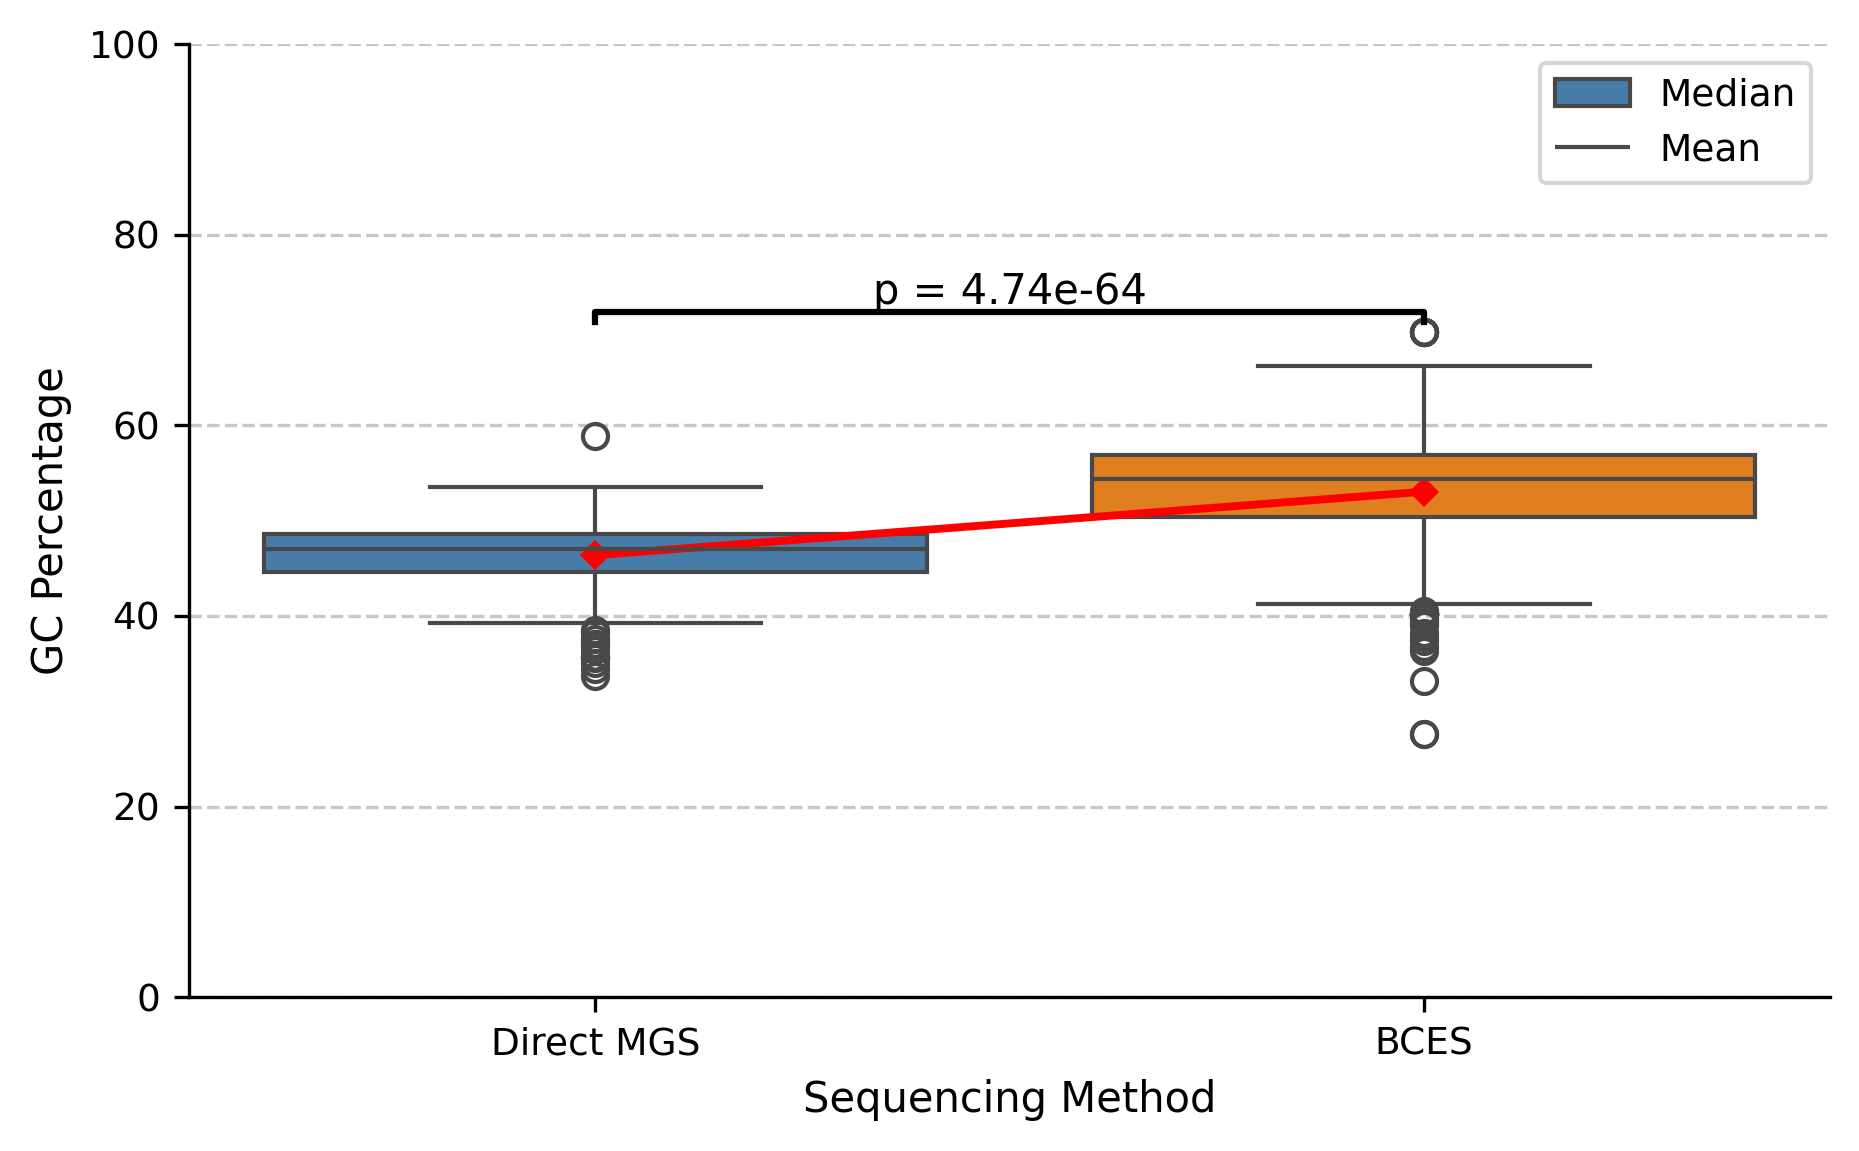

In [105]:
# Set global font sizes
rcParams["font.size"] = 10
rcParams["axes.titlesize"] = 12
rcParams["axes.labelsize"] = 10
rcParams["xtick.labelsize"] = 9
rcParams["ytick.labelsize"] = 9
rcParams["legend.fontsize"] = 9
rcParams["figure.titlesize"] = 14

# Create the plot
centimeters = 1 / 2.54  # centimeters in inches
plt.figure(figsize=(16 * centimeters, 10 * centimeters), dpi=300)
plt.grid(True, linestyle="--", alpha=0.7)

# Create the boxplot
ax = sns.boxplot(
    x="seq_method", y="gc_percentage", hue="seq_method", data=melted_df, legend=False
)

# Add mean points
sns.pointplot(
    x="seq_method",
    y="gc_percentage",
    data=melted_df,
    estimator=np.mean,
    color="red",
    markers="D",
    scale=0.7,
    errorbar=None,
    ax=ax,
)

plt.xlabel("Sequencing Method")
plt.ylabel("GC Percentage")
plt.ylim(0, 100)


# Add statistical annotation
def add_stat_annotation(ax):
    y_max = melted_df["gc_percentage"].max()
    x1, x2 = 0, 1
    y, h = y_max + 1, 1
    plt.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, color="black")
    stat, p = stats.mannwhitneyu(
        melted_df[melted_df["seq_method"] == "meta"]["gc_percentage"],
        melted_df[melted_df["seq_method"] == "captured"]["gc_percentage"],
    )
    plt.text(
        (x1 + x2) * 0.5, y + h, f"p = {p:.2e}", ha="center", va="bottom", color="black"
    )


add_stat_annotation(plt.gca())

ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xticks([0, 1])  # Set the tick locations
ax.set_xticklabels(["Direct MGS", "BCES"])  # Set the tick labels

# Add a legend
plt.legend(["Median", "Mean"], loc="upper right")

plt.tight_layout()
plt.show()

# The rest of your code for Mann-Whitney U test and mean calculation remains the same

### Bar charts by condition and sequencing method

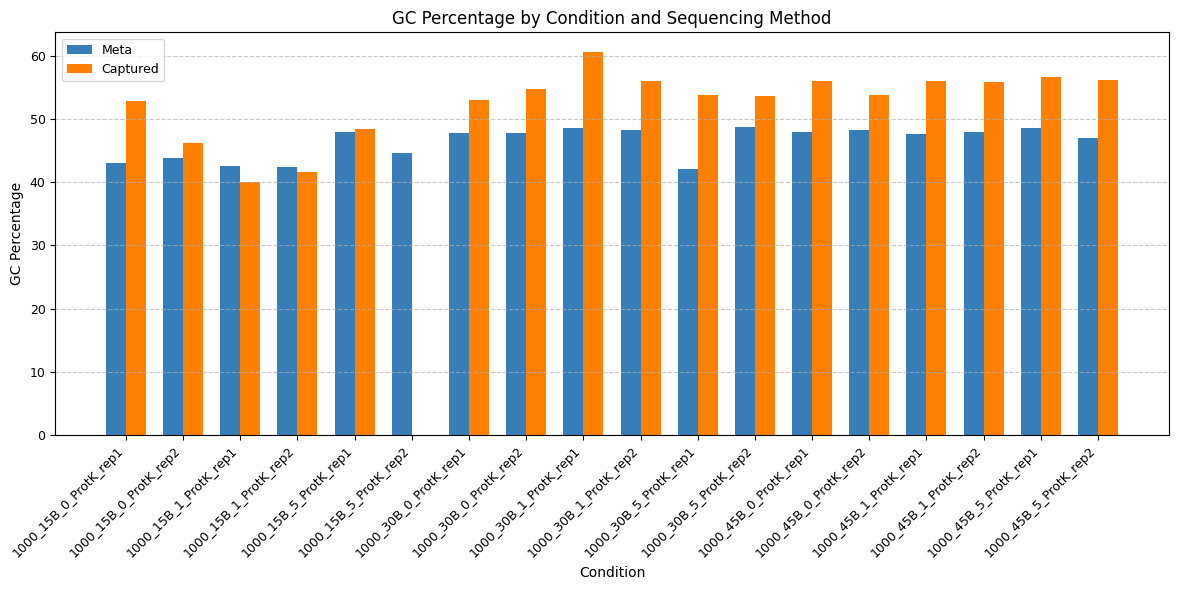

seq_method              captured       meta
condition                                  
1000_15B_0_ProtK_rep1  52.790920  43.067236
1000_15B_0_ProtK_rep2  46.256530  43.798347
1000_15B_1_ProtK_rep1  39.980545  42.489298
1000_15B_1_ProtK_rep2  41.601682  42.328018
1000_15B_5_ProtK_rep1  48.374277  47.987308
1000_15B_5_ProtK_rep2   0.000000  44.636218
1000_30B_0_ProtK_rep1  53.044410  47.730013
1000_30B_0_ProtK_rep2  54.651281  47.839268
1000_30B_1_ProtK_rep1  60.657306  48.619654
1000_30B_1_ProtK_rep2  55.963910  48.247865
1000_30B_5_ProtK_rep1  53.736655  42.024117
1000_30B_5_ProtK_rep2  53.679767  48.695980
1000_45B_0_ProtK_rep1  55.950417  47.919659
1000_45B_0_ProtK_rep2  53.749507  48.275953
1000_45B_1_ProtK_rep1  56.000679  47.669085
1000_45B_1_ProtK_rep2  55.803693  47.920201
1000_45B_5_ProtK_rep1  56.571469  48.500914
1000_45B_5_ProtK_rep2  56.147294  47.059607


In [106]:
# Pivot the data to have seq_method as columns and condition as index
grouped_data = off_target_gc.pivot(
    index="condition", columns="seq_method", values="Total"
)

# Set up the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Set the width of each bar and positions of the bars
width = 0.35
x = np.arange(len(grouped_data.index))

# Create the bars
ax.bar(x - width / 2, grouped_data["meta"], width, label="Meta", color="C0")
ax.bar(x + width / 2, grouped_data["captured"], width, label="Captured", color="C1")

# Customize the plot
ax.set_xlabel("Condition")
ax.set_ylabel("GC Percentage")
ax.set_title("GC Percentage by Condition and Sequencing Method")
ax.set_xticks(x)
ax.set_xticklabels(grouped_data.index, rotation=45, ha="right")
ax.legend()

# Add a grid for better readability
ax.grid(True, axis="y", linestyle="--", alpha=0.7)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

# Print the grouped data for verification
print(grouped_data)

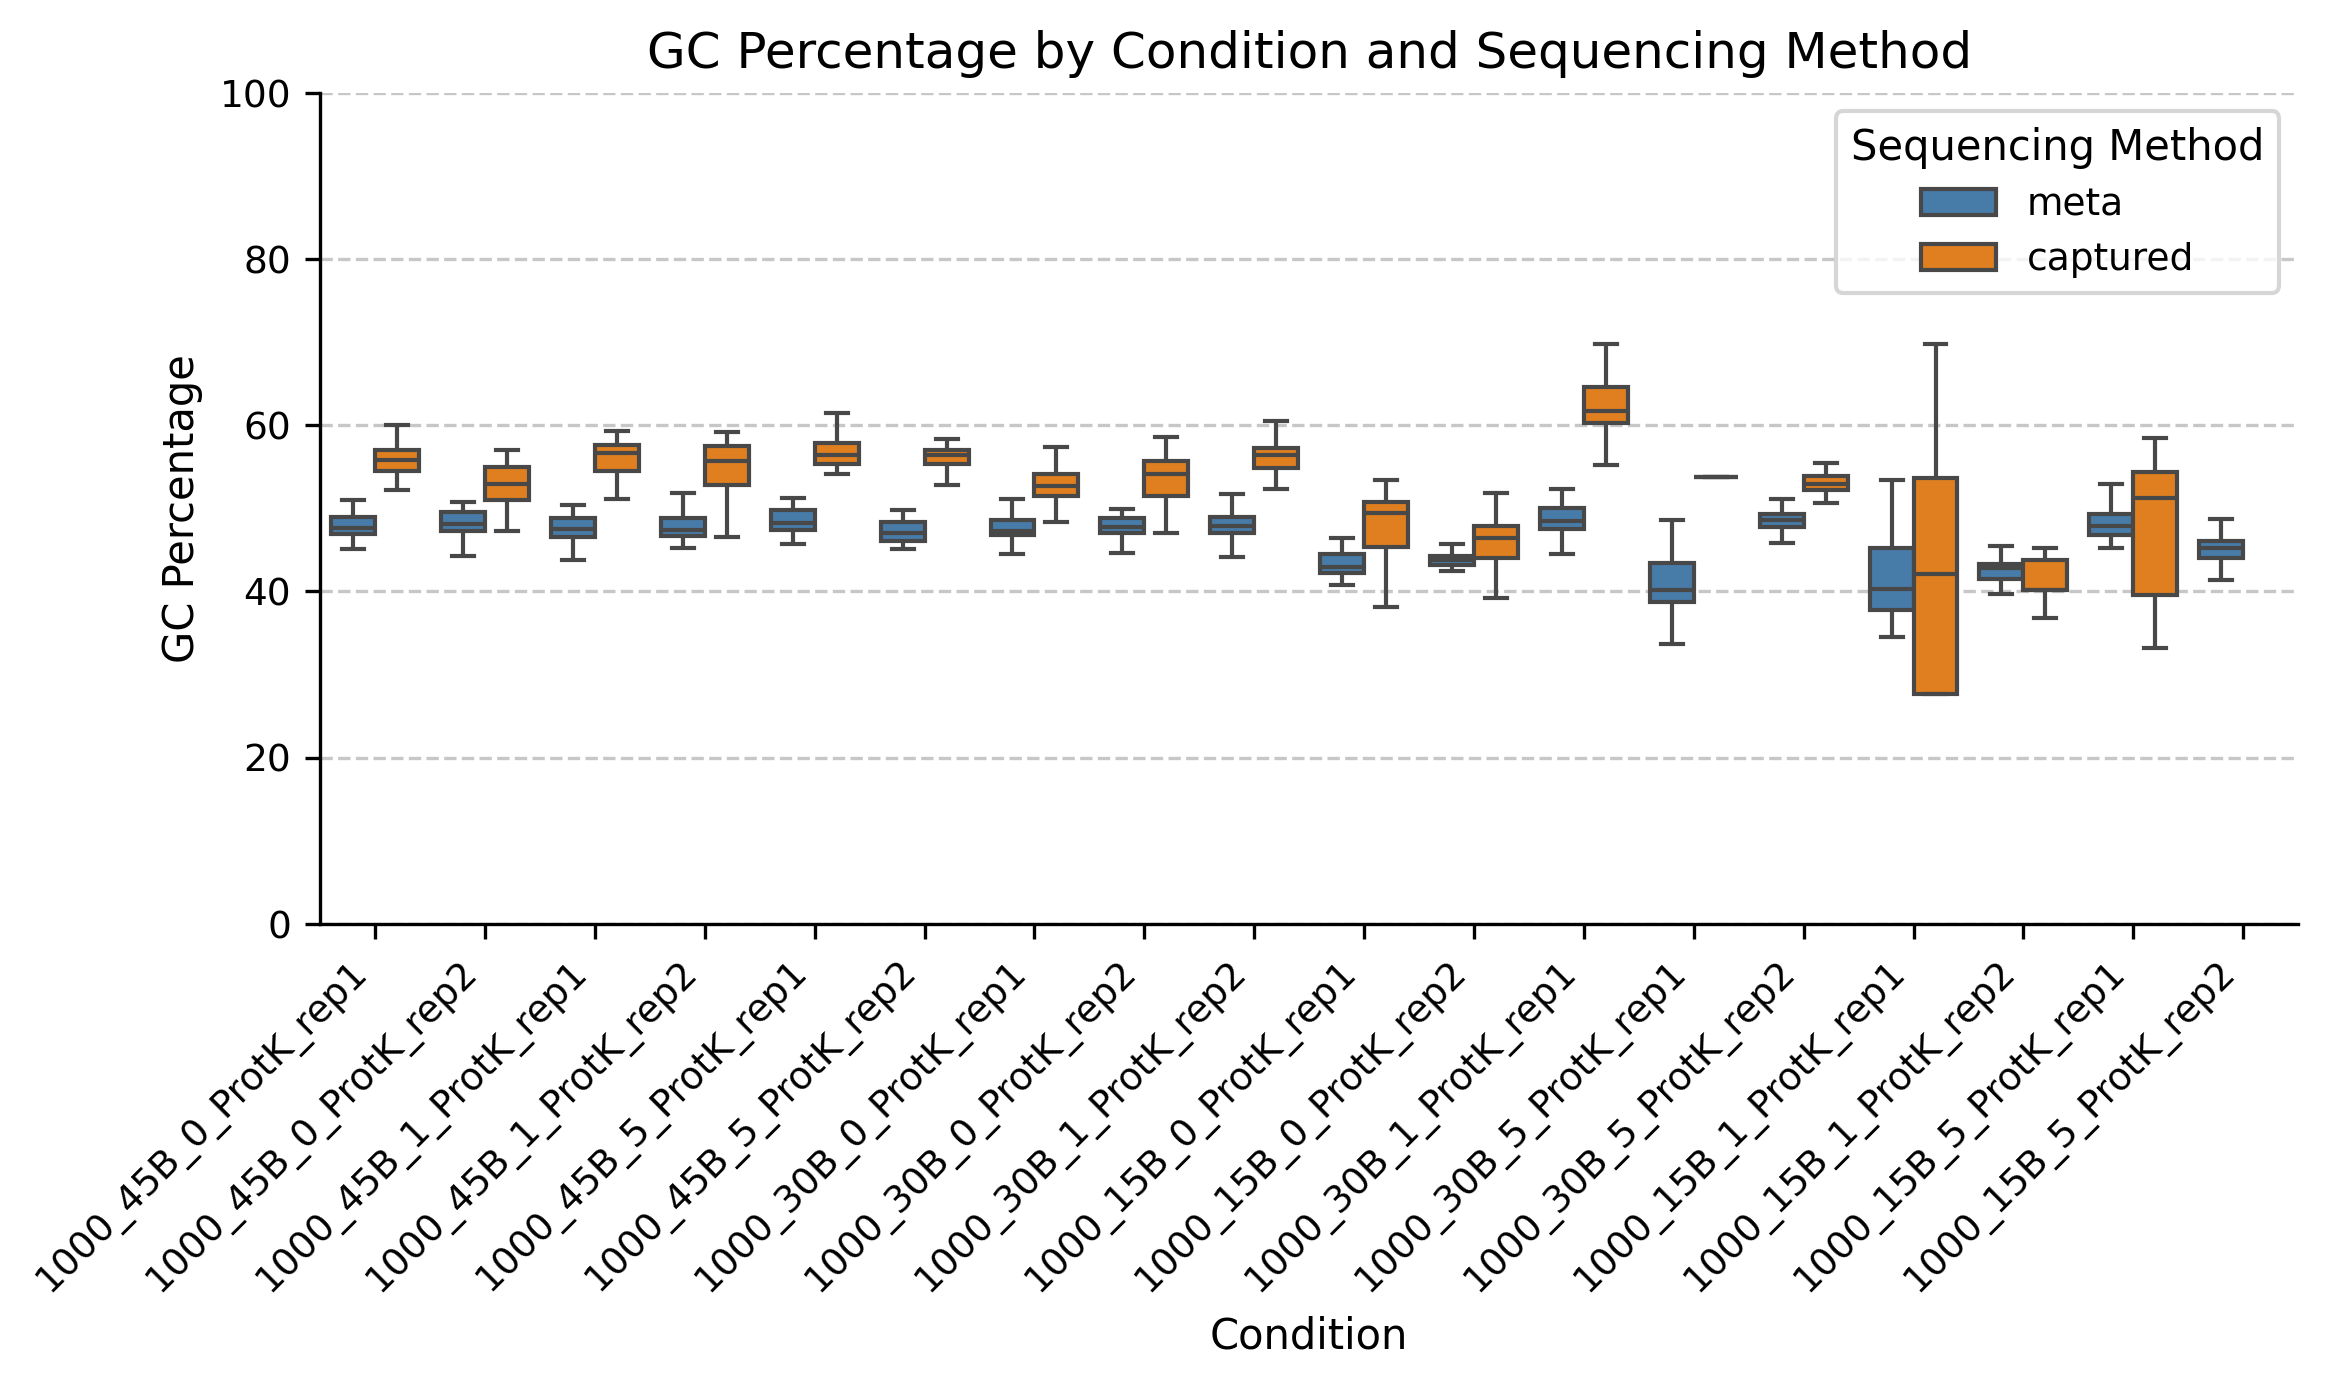

In [107]:
# Set global font sizes
rcParams["font.size"] = 10
rcParams["axes.titlesize"] = 12
rcParams["axes.labelsize"] = 10
rcParams["xtick.labelsize"] = 9
rcParams["ytick.labelsize"] = 9
rcParams["legend.fontsize"] = 9
rcParams["figure.titlesize"] = 14

# Create the plot
centimeters = 1 / 2.54  # centimeters in inches
plt.figure(figsize=(20 * centimeters, 12 * centimeters), dpi=300)

# Create the boxplot
sns.boxplot(
    x="condition", y="gc_percentage", hue="seq_method", data=melted_df, showfliers=False
)

# Customize the plot
plt.title("GC Percentage by Condition and Sequencing Method")
plt.xlabel("Condition")
plt.ylabel("GC Percentage")
plt.xticks(rotation=45, ha="right")
plt.ylim(0, 100)

# Adjust legend
plt.legend(title="Sequencing Method", loc="upper right")

# Add a grid for better readability
plt.grid(True, axis="y", linestyle="--", alpha=0.7)
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.tight_layout()
plt.show()

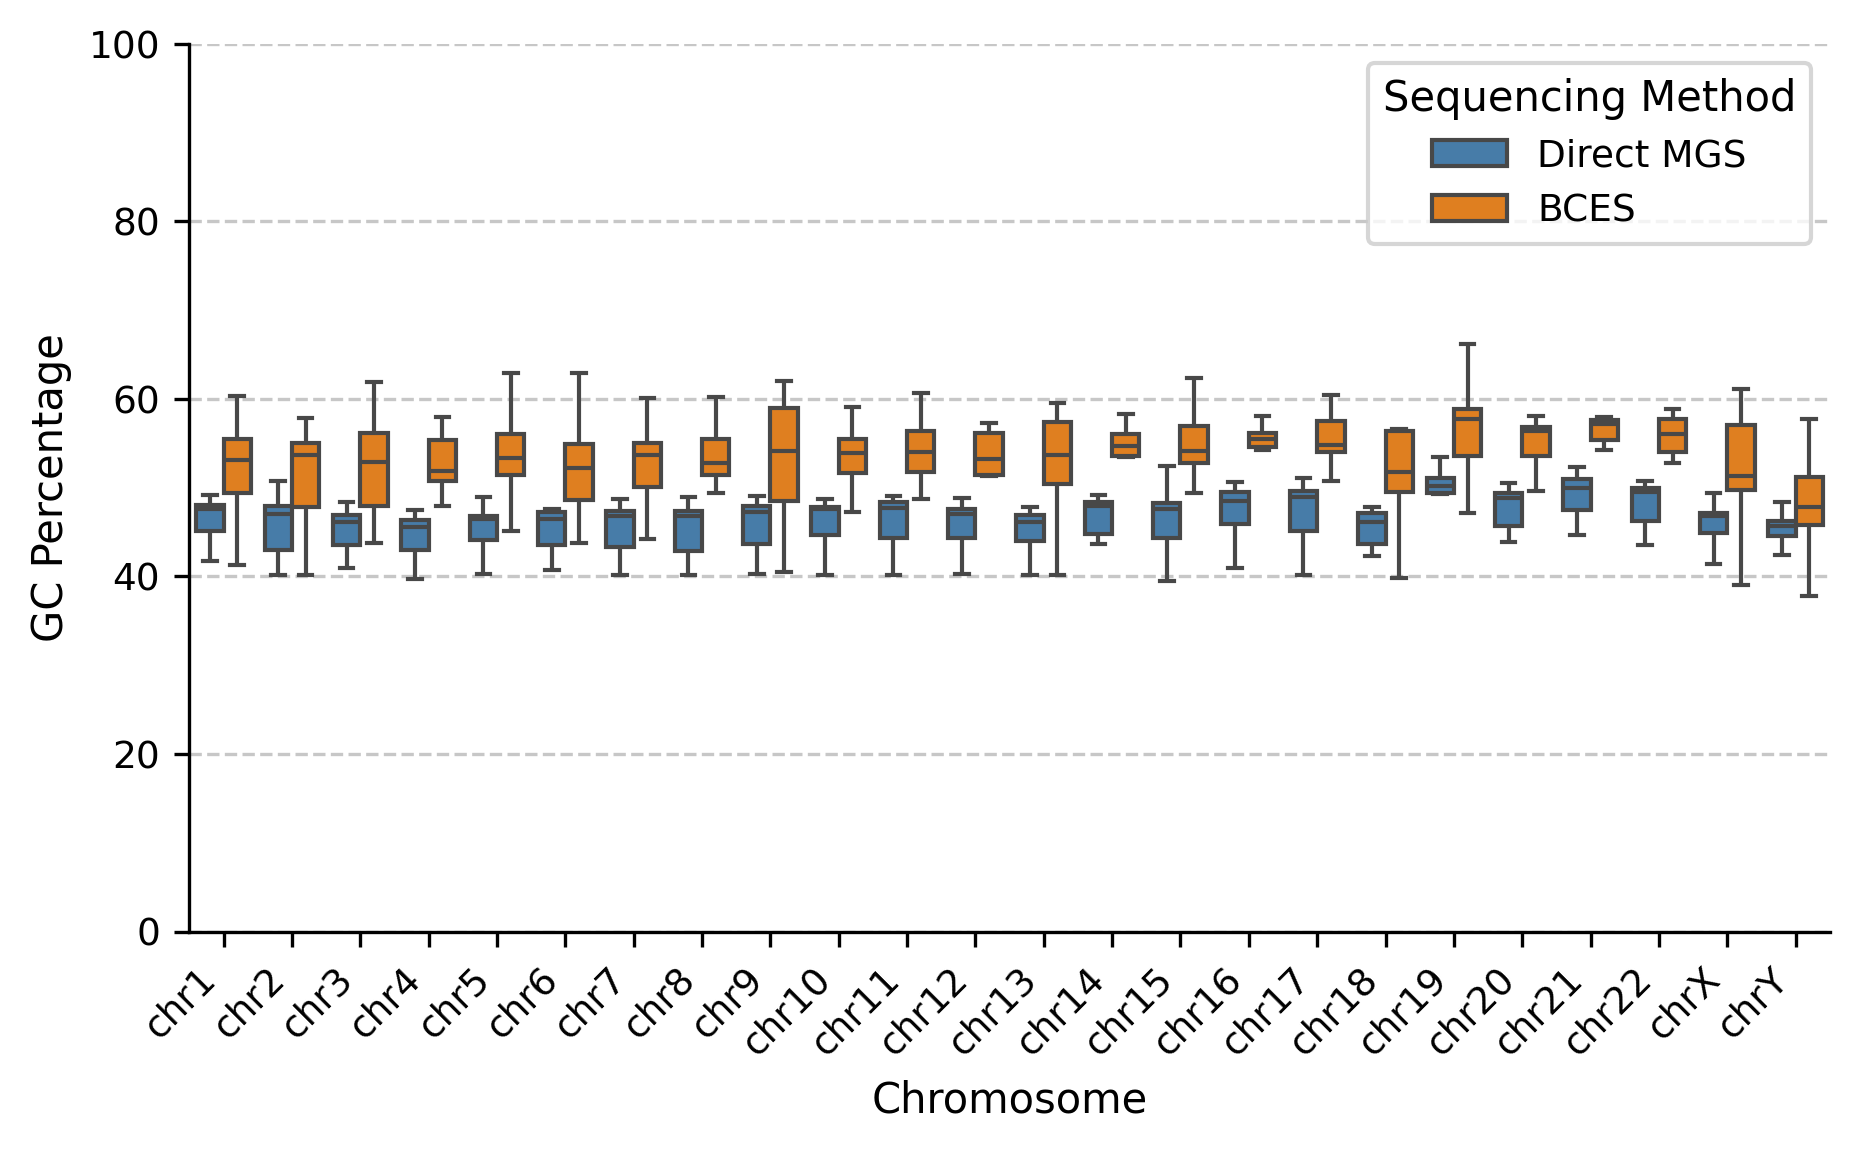

In [125]:
# filter out mitochondrial reads and unmapped reads because those are unecessary for this plot
filtered_df = melted_df.copy()

# Define the chromosomes to remove
chromosomes_to_remove = ["chrM", "chrRan", "chrUn"]

# Filter out the specified chromosomes
filtered_df = filtered_df[~filtered_df["chromosome"].isin(chromosomes_to_remove)]

# Use replace method to change the values
filtered_df["seq_method"] = filtered_df["seq_method"].replace(
    {"meta": "Direct MGS", "captured": "BCES"}
)

# Set global font sizes
rcParams["font.size"] = 10
rcParams["axes.titlesize"] = 12
rcParams["axes.labelsize"] = 10
rcParams["xtick.labelsize"] = 9
rcParams["ytick.labelsize"] = 9
rcParams["legend.fontsize"] = 9
rcParams["figure.titlesize"] = 14

# Create the plot
centimeters = 1 / 2.54  # centimeters in inches
plt.figure(figsize=(16 * centimeters, 10 * centimeters), dpi=300)

# Add grid before plotting data
plt.grid(True, linestyle="--", alpha=0.7)

# Create the boxplot
sns.boxplot(
    x="chromosome",
    y="gc_percentage",
    hue="seq_method",
    data=filtered_df,
    showfliers=False,
)

# Customize the plot
plt.xlabel("Chromosome")
plt.ylabel("GC Percentage")
plt.xticks(rotation=45, ha="right")
plt.ylim(0, 100)
plt.legend(title="Sequencing Method", loc="upper right")
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.tight_layout()
plt.show()

In [109]:
# Perform Mann-Whitney U test for each chromosome
results = []
for chromosome in chromosome_cols:
    meta_data = melted_df[
        (melted_df["chromosome"] == chromosome) & (melted_df["seq_method"] == "meta")
    ]["gc_percentage"]
    captured_data = melted_df[
        (melted_df["chromosome"] == chromosome)
        & (melted_df["seq_method"] == "captured")
    ]["gc_percentage"]

    statistic, p_value = stats.mannwhitneyu(
        meta_data, captured_data, alternative="two-sided"
    )
    results.append(
        {"chromosome": chromosome, "statistic": statistic, "p_value": p_value}
    )

# Create a DataFrame with the results
results_df = pd.DataFrame(results)

# Apply Bonferroni correction for multiple testing
results_df["p_value_corrected"] = results_df["p_value"] * len(chromosome_cols)
results_df["significant"] = results_df["p_value_corrected"] < 0.05

# Print the results
print(results_df)

   chromosome  statistic   p_value  p_value_corrected  significant
0        chrM       21.0  0.051282           1.384615        False
1        chr1       65.0  0.006759           0.182484        False
2        chr2       60.0  0.003964           0.107024        False
3        chr3       48.0  0.001764           0.047615         True
4        chr4       16.0  0.000032           0.000861         True
5        chr5       44.0  0.000597           0.016113         True
6        chr6       44.0  0.000597           0.016113         True
7        chr7       26.0  0.000157           0.004240         True
8        chr8       27.0  0.000183           0.004935         True
9        chr9       46.0  0.002528           0.068259        False
10      chr10       30.0  0.000158           0.004265         True
11      chr11       33.0  0.000138           0.003713         True
12      chr12       51.0  0.004654           0.125671        False
13      chr13       35.0  0.000586           0.015834         

In [110]:
# Function to perform Mann-Whitney U tests
def perform_pairwise_tests(data, group_col, value_col):
    groups = data[group_col].unique()
    results = []
    for group in groups:
        meta_data = data[(data[group_col] == group) & (data["seq_method"] == "meta")][
            value_col
        ]
        captured_data = data[
            (data[group_col] == group) & (data["seq_method"] == "captured")
        ][value_col]
        statistic, p_value = stats.mannwhitneyu(
            meta_data, captured_data, alternative="two-sided"
        )
        results.append({group_col: group, "statistic": statistic, "p_value": p_value})
    return pd.DataFrame(results)


# Chromosome comparisons
chromosome_results = perform_pairwise_tests(melted_df, "chromosome", "gc_percentage")

# Calculate Bonferroni-corrected significance threshold
n_tests_chromosomes = len(chromosome_results)
significance_threshold_chromosomes = 0.05 / n_tests_chromosomes

chromosome_results["significant"] = (
    chromosome_results["p_value"] < significance_threshold_chromosomes
)

print("Chromosome Comparison Results:")
print(chromosome_results[["chromosome", "p_value", "significant"]])
print(
    f"Bonferroni-corrected significance threshold: {significance_threshold_chromosomes}"
)

# Condition comparisons
condition_results = perform_pairwise_tests(melted_df, "condition", "gc_percentage")

# Calculate Bonferroni-corrected significance threshold for conditions
n_tests_conditions = len(condition_results)
significance_threshold_conditions = 0.05 / n_tests_conditions

condition_results["significant"] = (
    condition_results["p_value"] < significance_threshold_conditions
)

print("\nCondition Comparison Results:")
print(condition_results[["condition", "p_value", "significant"]])
print(
    f"Bonferroni-corrected significance threshold: {significance_threshold_conditions}"
)

Chromosome Comparison Results:
   chromosome   p_value  significant
0        chrM  0.051282        False
1        chr1  0.006759        False
2        chr2  0.003964        False
3        chr3  0.001764         True
4        chr4  0.000032         True
5        chr5  0.000597         True
6        chr6  0.000597         True
7        chr7  0.000157         True
8        chr8  0.000183         True
9        chr9  0.002528        False
10      chr10  0.000158         True
11      chr11  0.000138         True
12      chr12  0.004654        False
13      chr13  0.000586         True
14      chr14  0.000157         True
15      chr15  0.000212         True
16      chr16  0.000061         True
17      chr17  0.000442         True
18      chr18  0.002864        False
19      chr19  0.000674         True
20      chr20  0.000048         True
21      chr21  0.000383         True
22      chr22  0.000137         True
23     chrRan  0.001328         True
24      chrUn  0.000286         True
25     

ValueError: `x` and `y` must be of nonzero size.

## Calculate total read numbers

In [124]:
# Load mapped PacBio data of negative control samples pre- vs. post-enrichment
read_numbers = pd.read_excel(
    "../off_target_gc_content/off_target_gc_content.xls",
    sheet_name="read_numbers",
    engine="xlrd",
    skiprows=[1, 38],  # Skip the second row (index 1)
)

# Rename only the first two columns
read_numbers = read_numbers.rename(
    columns={
        read_numbers.columns[0]: "seq_method",
        read_numbers.columns[1]: "condition",
    }
)

print(read_numbers.columns)

Index(['seq_method', 'condition', 'chrMtotal_gc_percent', 'read_number',
       'lenght_total', 'gc_total', 'chr1total_gc_percent', 'read_number.1',
       'lenght_total.1', 'gc_total.1',
       ...
       'gc_total.25', 'chrYtotal_gc_percent', 'read_number.26',
       'lenght_total.26', 'gc_total.26', 'EBV', 'read_number.27',
       'lenght_total.27', 'gc_total.27', 'Overall GC %'],
      dtype='object', length=115)
